<center><h1>Stack Overflow Search Engine</h1></center>

In [0]:
#installing packages (since i'm using google colab,i'm installing from notebook itself)

#%%capture
#!pip3 install --upgrade tensorflow-gpu
#!pip install tensorflow --upgrade
#!pip install  tensorflow-addons

In [0]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import multiprocessing as mp
import heapq
from wordcloud import WordCloud
import gensim
import pickle
import random
import time
from sklearn.metrics import f1_score
import datetime
import os
from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import MultiLabelBinarizer

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Embedding,LSTM,Flatten,Dense,Dropout,Conv1D,MaxPooling1D,concatenate,TimeDistributed
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History,ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,LearningRateScheduler


from google.colab import auth
from google.cloud import bigquery
from google.colab import drive

from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import tensorflow_addons as tfa
from tensorflow_addons.metrics.utils import MeanMetricWrapper


<h1>Mounting the Drive </h1>

In [0]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


<h1>Variables</h1>

In [0]:
currentDirectory = "/content/drive/My Drive/pcase_study_1/"
dataDirectory = currentDirectory + "data/"
modelsDirectory = currentDirectory + "models/"

<h1>Reading Word2Vec Model</h1>


In [0]:
#reading Pre-Trained W2V
model_w2v = gensim.models.word2vec.Word2Vec.load(modelsDirectory+'w2v.bin') #reading pre-trained

<p>The purpose of this model is predict the tags of the user query and giving more importance to those while retrieving relevant results.We will train this model using the complete_question</p>

#<h1>1. Loading data<h1>

In [0]:
X_train = pd.read_csv(dataDirectory + 'train_data.csv')
X_test = pd.read_csv(dataDirectory + 'test_data.csv')

In [0]:
X_train.head(2)

,id,processed_title,complete_question,total_text,score,tags,sentiment_polarity,sentiment_subjectivity,neg,neu,pos,compound
0,17343032,implement converters entities java generics,implement converters entities java generics wo...,implement converters entities java generics wo...,16,java|spring|jsf|generics,0.008679,0.359622,0.032,0.798,0.170,0.9928
1,17110104,method use instead hazelcastgetmapmap,method use instead hazelcastgetmapmap using pr...,method use instead hazelcastgetmapmap using pr...,4,java|collections,0.225000,0.450000,0.000,0.943,0.057,0.2500


In [0]:
#convertiing pipe seperated tags to list
y_train = X_train['tags'].apply(lambda x: str(x).split('|')).values
y_test = X_test['tags'].apply(lambda x: str(x).split('|')).values

In [0]:
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
X_train['complete_question'] = X_train['complete_question'].astype(str)#complete_question #processed_title
X_test['complete_question'] = X_test['complete_question'].astype(str)

X_train_title = X_train['complete_question'].values
X_test_title = X_test['complete_question'].values

In [0]:
print(X_train_title)

['implement converters entities java generics working jsf project spring hibernate among things number follow pattern receives string representation object converts number fetch entity given kind given receives entity returns object converted code essentially follows checks omitted managedbeannamemyconvertersessionscopedpublic class myconverter implements converter private myservice myservice override public object getasobjectfacescontext facescontext uicomponent uicomponent string value int integerparseintvalue return myservicegetbyidid override public string getasstringfacescontext facescontext uicomponent uicomponent object value return myentityvaluegetidtostring given large number exactly like except type course wondering worth using single generic converter implementation generic difficult sure right approach declare beans possible solution following 1 write generic implementation let call without bean annotation 2 write specific converter ad subclass annotate needed managedbeanna

In [0]:
print(y_train)

[list(['java', 'spring', 'jsf', 'generics']) list(['java', 'collections'])
 list(['java', 'jbutton']) ... list(['java', 'cdi'])
 list(['python', 'python-3.x', 'pandas', 'dataframe'])
 list(['python', 'multiprocessing'])]


#<h1>2. One hot encode of Tags<h1>

In [0]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

#we will be saving this MultiLabelBinarizer to predict tags of the user query
with open(modelsDirectory+'multiLabel.pickle', 'wb') as f:
    pickle.dump(mlb, f, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
print("shape of the Tags(Train):",y_train.shape)
print("shape of the Tags(Train):",y_test.shape)

shape of the Tags(Train): (743584, 750)
shape of the Tags(Train): (185896, 750)


<p>we have 750 class labels in both train and test</p>

#<h1>3. Tokenizing the text<h1>

In [0]:
def filterTextWithModelWords(model,WordList):
    return [word for word in WordList if  word in model.wv]


#we alredy trained W2V model and we have a vaocb in that model.tokenizing entire corpus and is killing ram and my drive storage,
#so to save ram i'm filtering the corpus



In [0]:
tokenizer = Tokenizer(filters='',split=' ') #creating tokenizer
tokenizer.fit_on_texts(corpus) #X_train text to the tokenizer

with open(modelsDirectory+'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

X_train_token = tokenizer.texts_to_sequences(X_train_title)#converting text to int sequence
X_test_token = tokenizer.texts_to_sequences(X_test_title)#converting text to int sequence
vocab_size = len(tokenizer.word_index) + 1 #getting vocab size from tokenizer

print("Number Of words in in vocab: ",vocab_size)

Number Of words in in vocab:  346929


In [0]:
#after tokenization will be deleting un-used variables
del X_train_title
del X_test_title

<h2>Saving tokenizer using pickle</h2>

In [0]:
#with open(modelsDirectory+'tokenizer.pickle', 'wb') as f:
#    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

#<h2>4. Sequence Length</h2>

In [0]:
len_seq = []
for seq in X_train_token:
    len_seq.append(len(seq))
print("Max Number of Words in a sequence: ",max(len_seq))
print("*"*100)
for i in range(0,15):
    print(85+i,'percentile value is',np.percentile(len_seq,85+i))

Max Number of Words in a sequence:  6093
****************************************************************************************************
85 percentile value is 139.0
86 percentile value is 144.0
87 percentile value is 150.0
88 percentile value is 155.0
89 percentile value is 162.0
90 percentile value is 170.0
91 percentile value is 178.0
92 percentile value is 188.0
93 percentile value is 200.0
94 percentile value is 215.0
95 percentile value is 232.0
96 percentile value is 256.0
97 percentile value is 289.0
98 percentile value is 343.0
99 percentile value is 455.0


<p>as we can see 85-87% of questions have sequence length as 150,so we will be taking 150 as length of the each question </p>

In [0]:
X_train_pad = pad_sequences(X_train_token, maxlen=150, padding='pre')
X_test_pad = pad_sequences(X_test_token, maxlen=150, padding='pre')

In [0]:
#after padding will be deleting un-used variables
del X_train_token
del X_test_token
del len_seq

#<h1>5. Preparing Embedding matrix<h1>

<p>Creating Embedding Matrix for Nueral Network Model</p>

In [0]:
count = 0
emb_matrix = np.zeros((vocab_size, 300)) #creating empty matrix with shape of vocab_size and 300
for word, i in tokenizer.word_index.items(): #iterating through all the words in vocan
    if word in model_w2v.wv: #to check whether word id thre in pre-trained model
        count += 1
        emb_matrix[i] = model_w2v.wv[word] #updating embedding_matrix if word existinfg in W2V

<h2>Saving Embedding matrix</h2>

In [0]:
np.save(modelsDirectory + 'emb_matrix', emb_matrix)

#<h1>6. Modeling</h1>

<h2>6.1 Creating custom callback's</h2>

In [0]:
#custom callback implementation..this is an derived class of tf.keras.Callback
class CustomCallback(Callback):
        
    def on_train_begin(self, logs={}):
        #on begin of training, we are creating a instance varible called history
        #it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'val_hamming_loss': []} 
            
    def on_epoch_end(self, epoch, logs={}): #after an epoch ends,this method will be excuted 
        #history = self.model.evaluate(validation_data[0], validation_data[1], verbose=1)

        val_predict = np.asarray(self.model.predict(validation_data[0])) #getting preditions of valdition data from model
        val_targ = validation_data[1] #gettinf actual predictions of valdition data
        
        _val_hamming_loss = np.asarray(K.mean(hamming_loss_fn(val_targ, val_predict, 0.5, 'multilabel')))
        
        val_hamming_loss.append(_val_hamming_loss)
        #on end of each epoch, we will get logs and update the self.history dict
        self.history['val_hamming_loss'].append(_val_hamming_loss)

        print("")
        #printing f1-score,auc score,acuuracy,loss
        print(str.format("Epoch: {0:02d}  val_hamming_loss: {1:.5f} ",epoch+1,self.history['val_hamming_loss'][epoch]))           

def callBacksList():
    """
    returns list of callback's
    """
    filepath = modelsDirectory + ModelName + "/best1.hdf5"
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=1)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)

    #directory for tensorboard to save evnts
    log_dir= modelsDirectory + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,write_graph=True)

    history = History()
    callbacks_list = [reduce_lr,early_stop, history,tensorboard_callback,checkpoint,CustomCallback()]
    return callbacks_list

<h2>6.2 Hamming loss as Metric</h2>

<p>Hamming loss : The Hamming loss is the fraction of labels that are incorrectly predicted.</p>
https://www.kaggle.com/wiki/HammingLoss

In [0]:
#https://colab.research.google.com/drive/1Msuv5xUu7lu5wDH1ei-VOPB-UnBolDfB#scrollTo=cyfF48B7SZi_
def hamming_loss_fn(y_true, y_pred, threshold, mode):
    """
    Computes hamming loss.

    Hamming loss is the fraction of wrong labels to the total number
    of labels.
    """
    if mode not in ['multiclass', 'multilabel']:
        raise TypeError('mode must be: [multiclass, multilabel]')
    
    if threshold is None:
        threshold = tf.reduce_max(y_pred, axis=-1, keepdims=True)
        # make sure [0, 0, 0] doesn't become [1, 1, 1]
        # Use abs(x) > eps, instead of x != 0 to check for zero
        y_pred = tf.logical_and(y_pred >= threshold,
                                    tf.abs(y_pred) > 1e-12)
    else:
        y_pred = y_pred > threshold

    if mode == 'multiclass':
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.int32)
        nonzero = tf.cast(
            tf.math.count_nonzero(y_true * y_pred, axis=-1), tf.float32)
        return 1.0 - nonzero

    else:
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)
        nonzero = tf.cast(
            tf.math.count_nonzero(tf.math.logical_xor(y_true, y_pred), axis=-1), tf.float32)
        if y_true.get_shape()[-1] is None:
            return nonzero / 750
        else:
            return nonzero / y_true.get_shape()[-1]

class HammingLoss(MeanMetricWrapper):
    """
    Computes hamming loss
    """
    def __init__(self, mode, name='hamming_loss', threshold=None, dtype=tf.float32):
        super(HammingLoss, self).__init__(hamming_loss_fn, name, dtype=dtype, mode=mode, threshold=threshold)

<h2>6.3 Building the model</h2>

In [0]:
def buildTagClassifier():
    """
    Creating Tag Classifier Model
    """
    tf.keras.backend.clear_session()

    Input_title = Input(shape=input_length,name='Input_Title')
    
    Emb_title = Embedding(input_dim=emb_matrix.shape[0], output_dim=emb_matrix.shape[1],weights=[emb_matrix], trainable=False,
                          name="Embedding_Layer")(Input_title)

    
    Lstm_title = LSTM(1024,name="LSTM_Layer",recurrent_dropout=0.2,dropout=0.2,kernel_regularizer=l2(l2_alpha))(Emb_title)

    flatten_title = Flatten(name="Flatten_lstm")(Lstm_title)

    currentOutput = Emb_title
    conv_filters = [2048,2048,1024,1024,512,512]
    for i in range(len(conv_filters)):
        conv = Conv1D(conv_filters[i], 3,padding='same', activation='relu', kernel_initializer='glorot_uniform',name="Conv1D-"+str(i+1),
                      kernel_regularizer=l2(l2_alpha))(currentOutput)
        maxPooling = MaxPooling1D(2,2,name="MaxPooling1D-"+str(i+1))(conv)
        currentOutput = maxPooling
    
    flatten_conv = Flatten(name="Flatten_Conv")(currentOutput)

    concatenateLayer = concatenate([flatten_title,flatten_conv],name="Concatenate")
    
    currentOutput = concatenateLayer
    nodes = [8192,4096,2048,1024]
    for i in range(len(nodes)):
        dropout = Dropout(rate=0.4,name="DropOut_"+str(i+1))(currentOutput)
        dense = Dense(nodes[i], activation='relu', kernel_initializer='glorot_uniform', name="Dense_"+str(i+1),
                      kernel_regularizer=l2(l2_alpha))(dropout)
        currentOutput = dense

    final_output = Dense(750, activation='sigmoid', kernel_initializer='glorot_uniform',name="OutputLayer",
                         kernel_regularizer=l2(l2_alpha))(currentOutput)


    inputs = Input_title
    
    model = Model(inputs=inputs, outputs=final_output)

    model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy',tfa.metrics.F1Score(750,'macro'),
                                                                            HammingLoss(mode='multilabel',threshold=0.5)])
    return model

![alt text](https://i.ibb.co/qpyT3Zg/tag-Classifier.png)

<h2>6.4 Model Training</h2>

In [0]:
ModelName = 'tagClassifier'
emb_matrix = np.load(modelsDirectory + 'emb_matrix.npy')

#X_train_pad
#X_test_pad

batch_size = 128
l2_alpha = 0
input_length = X_train_pad.shape[1]
validation_data = (X_test_pad,y_test)
val_hamming_loss = []

In [0]:
tagClassifier = buildTagClassifier()
#tf.keras.utils.plot_model(tagClassifier,to_file=modelsDirectory + 'tagClassifier/' +'tagClassifier.png',show_shapes=True,show_layer_names=True)
history = tagClassifier.fit(x=X_train_pad,y=y_train,batch_size=batch_size,validation_data=validation_data,callbacks=callBacksList(),
                            validation_freq=1,epochs=10,verbose=1)

TensorBoard Folder for this Execution /content/drive/My Drive/pcase_study_1/models/logs/fit/tagClassifier/20200224-143638
Train on 743584 samples, validate on 185896 samples
Epoch 1/10
743552/743584 [============================>.] - ETA: 0s - loss: 8.3823 - accuracy: 0.3257 - f1_score: 0.0107 - hamming_loss: 0.0025
Epoch 00001: val_loss improved from inf to 6.22069, saving model to /content/drive/My Drive/pcase_study_1/models/tagClassifier/best1.hdf5

Epoch: 01  val_hamming_loss: 0.00205 
743584/743584 [==============================] - 3548s 5ms/sample - loss: 8.3822 - accuracy: 0.3257 - f1_score: 0.0107 - hamming_loss: 0.0025 - val_loss: 6.2207 - val_accuracy: 0.3579 - val_f1_score: 0.0292 - val_hamming_loss: 0.0020
Epoch 2/10
743552/743584 [============================>.] - ETA: 0s - loss: 6.5758 - accuracy: 0.3403 - f1_score: 0.0261 - hamming_loss: 0.0021
Epoch 00002: val_loss improved from 6.22069 to 5.86234, saving model to /content/drive/My Drive/pcase_study_1/models/tagClassif

<table style="font-size:20px">
<tr>
    <td><img src='https://i.ibb.co/WxbpWBM/accuracy.png'></td>
    <td><img src='https://i.ibb.co/R2JrGrB/f1-score.png'></td>
</tr>
<tr>
    <td><img src='https://i.ibb.co/wpmkrFJ/hamming-loss.png'></td>
    <td><img src='https://i.ibb.co/q9Yj172/loss.png'></td>
</tr>
</table>

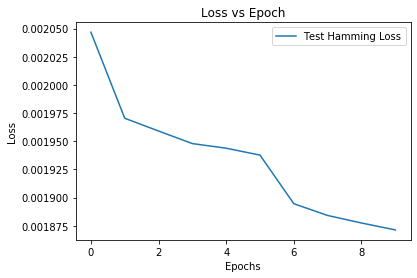

In [0]:
plt.plot(val_hamming_loss,label="Test Hamming Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

<h2>6.5 Model Evaluation</h2>

In [0]:
tagClassifier = buildTagClassifier()
tagClassifier.load_weights(modelsDirectory + ModelName + "/best1.hdf5")

def predict_tags(model,X,encoder):
    X = X.reshape(1,-1)
    prediction = model.predict(X)[0]
    prediction = np.array(prediction >= 0.5,dtype=np.int32)
    
    tags = encoder.inverse_transform(np.array([prediction]))
    return tags

In [0]:
test_idx = np.random.randint(len(X_test_pad), size=5)

for idx in test_idx:
    test_case = idx
    print('Test Case: ' + str(X_test['processed_title'][test_case]))
    print('-'*100)
    print('Predicted: ' + str(predict_tags(tagClassifier,X_test_pad[test_case],mlb)))
    print('Ground Truth: ' + str(mlb.inverse_transform(np.array([y_test[test_case]]))))
    print('\n')

Test Case: using django automatically update information template
----------------------------------------------------------------------------------------------------
Predicted: [('django', 'python')]
Ground Truth: [('django', 'django-templates', 'django-views', 'python')]


Test Case: remove first number surrounded space
----------------------------------------------------------------------------------------------------
Predicted: [('java', 'string')]
Ground Truth: [('java', 'regex')]


Test Case: use python script external tool intellij idea
----------------------------------------------------------------------------------------------------
Predicted: [('python',)]
Ground Truth: [('intellij-idea', 'java', 'python')]


Test Case: efficient way implement multiple threads within thread
----------------------------------------------------------------------------------------------------
Predicted: [('java', 'multithreading')]
Ground Truth: [('concurrency', 'java', 'multithreading')]


Tes